In [14]:
using LinearAlgebra
using Plots
using OffsetArrays
using SparseArrays
using BandedMatrices
using BenchmarkTools

In [67]:
function ptrans_i(A::AbstractMatrix{T}, y::AbstractVector{T}) where T <: Number
    n = size(A, 1)
    e = @views OffsetArray(A[band(-2)], 3:n)
    c = @views OffsetArray(A[band(-1)], 2:n)
    d = @view A[band(0)]
    a = @view A[band(1)]
    b = @view A[band(2)]

    α = Vector{T}(undef, n-1)
    β = Vector{T}(undef, n-2)
    z = Vector{T}(undef, n)
    γ = Vector{T}(undef, n)
    μ = Vector{T}(undef, n)
    
    i = 1
    μ[i] = d[i]
    z[i] = y[i]/μ[i]
    α[i] = a[i]/μ[i]
    β[i] = b[i]/μ[i]
    
    i = 2
    γ[i] = c[i]
    μ[i] = d[i] - α[i-1]*γ[i]
    z[i] = (y[i] - z[i-1]*γ[i])/μ[i]
    α[i] = (a[i] - β[i-1]*γ[i])/μ[i]
    β[i] = b[i]/μ[i]

    for i in 3:n
        γ[i] = c[i] - α[i-2]*e[i]
        μ[i] = d[i] - β[i-2]*e[i] - α[i-1]*γ[i]
        z[i] = (y[i] - z[i-2]*e[i] - z[i-1]*γ[i])/μ[i]

        if i <= n - 1
            α[i] = (a[i] - β[i-1]*γ[i])/μ[i] 
        end
        
        if i <= n - 2 
            β[i] = b[i]/μ[i]
        end
    end
    
    n = size(A, 1)
    ut = BandedMatrix{T}(undef, (n, n), (0, 2))
    ut[band(1)] = α
    ut[band(2)] = β

    ut = UnitUpperTriangular(ut)
    X =  ut \ z
    return X
end

ptrans_i (generic function with 4 methods)

In [145]:
n = 10000
A = rand(n, 5) .- 0.5

A_full = BandedMatrix{Float64}(undef, (n, n), (2, 2))

A_full[band(-2)] = A[3:end, 1]
A_full[band(-1)] = A[2:end, 2]
A_full[band(0)] = A[:, 3]
A_full[band(1)] = A[1:n-1, 4]
A_full[band(2)] = A[1:n-2, 5]

b = rand(n)

@time for i in 1:200;X1 = ptrans_i(A_full, b); end # PTRANS-I
@time for i in 1:200;X2 = A_full \ b;end

  0.106301 seconds (3.00 k allocations: 137.402 MiB, 4.65% gc time)
  0.146566 seconds (3.20 k allocations: 167.938 MiB, 4.74% gc time)


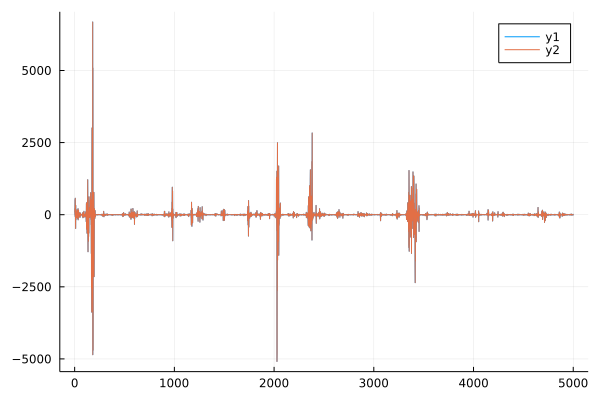

In [111]:
plot(X1)
plot!(X2)

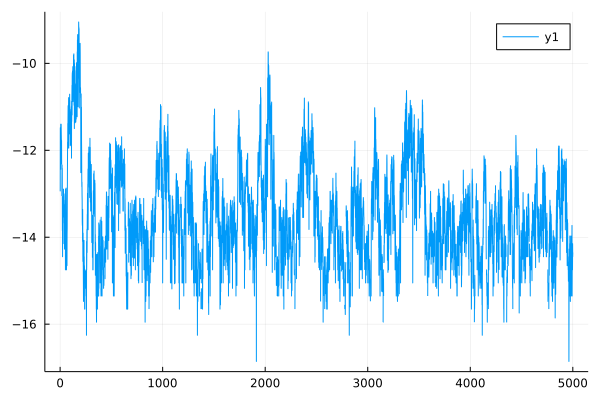

In [106]:
# Error in log scale
plot(log10.(abs.(X1 - X2)))

In [107]:
A = rand(5, 5)
A[band(-2)]

3-element Vector{Float64}:
 0.40132353917446273
 0.9777624817616352
 0.09005693949111315

In [24]:
SparseMatrixCSC{Float64, Int64} <: (AbstractMatrix{T} where T <: Number)

true

In [125]:
A_full = BandedMatrix{Float64}(undef, (n, n), (2, 2))


5000×5000 BandedMatrix{Float64} with bandwidths (2, 2):
 8.103e-321  8.103e-321  8.103e-321  …    ⋅         ⋅           ⋅ 
 8.09e-321   8.11e-321   8.11e-321        ⋅         ⋅           ⋅ 
 8.093e-321  8.093e-321  8.113e-321       ⋅         ⋅           ⋅ 
  ⋅          8.1e-321    8.1e-321         ⋅         ⋅           ⋅ 
  ⋅           ⋅          8.103e-321       ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅          …    ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅               ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅               ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅               ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅               ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅          …    ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅               ⋅         ⋅           ⋅ 
  ⋅           ⋅           ⋅               ⋅         ⋅           ⋅ 
 ⋮                                   ⋱                        
  ⋅       